# VAR Example Oil
by **Professor Throckmorton**  
for *Time Series Econometrics*  
W&amp;M ECON 408/PUBP 616  
<!--- <a href="review-2A-key.slides.html">Slides</a> --->

## VAR

Big oil price increases are often associated with declines in production and asset prices. Read data on the price of crude oil (WTISPLC), industrial production (INDPRO), the S&P 500 (SP500), and the core consumer price index (CPILFESL).

In [1]:
# Libraries
from fredapi import Fred
import pandas as pd
# Setup acccess to FRED
fred_api_key = pd.read_csv('fred_api_key.txt', header=None).iloc[0,0]
fred = Fred(api_key=fred_api_key)
# Series to get
series = ['WTISPLC','INDPRO','SP500','CPILFESL']
rename = ['oil','prod','sp','price']
# Get and append data to list
dl = []
for idx, string in enumerate(series):
    var = fred.get_series(string).to_frame(name=rename[idx])
    dl.append(var)
    print(var.head(2)); print(var.tail(2))

             oil
1946-01-01  1.17
1946-02-01  1.17
              oil
2025-05-01  62.17
2025-06-01  68.17
              prod
1919-01-01  4.8654
1919-02-01  4.6504
                prod
2025-05-01  103.6602
2025-06-01  104.0071
                 sp
2015-08-03  2098.04
2015-08-04  2093.32
                 sp
2025-07-30  6362.90
2025-07-31  6339.39
            price
1957-01-01   28.5
1957-02-01   28.6
              price
2025-05-01  326.854
2025-06-01  327.600


In [2]:
# Concatenate data to create data frame (time-series table)
raw = pd.concat(dl, axis=1).sort_index()
# Make all columns numeric
raw = raw.apply(pd.to_numeric, errors='coerce')
# Resample/reindex to quarterly frequency
raw = raw.resample('ME').mean().dropna()
# Display dataframe
display(raw)

oil      prod           sp    price
2015-08-31  42.87  100.9165  2039.866190  242.817
2015-09-30  45.48  100.6330  1944.402381  243.316
2015-10-31  46.22  100.1563  2024.812727  243.768
2015-11-30  42.44   99.4366  2080.616500  244.241
2015-12-31  37.19   98.9471  2054.079545  244.547
...           ...       ...          ...      ...
2025-02-28  71.53  103.9397  6038.690000  325.475
2025-03-31  68.24  103.6682  5683.983333  325.659
2025-04-30  63.54  103.6912  5369.495714  326.430
2025-05-31  62.17  103.6602  5810.919524  326.854
2025-06-30  68.17  104.0071  6029.951500  327.600

[119 rows x 4 columns]

In [3]:
# Scientific computing
import numpy as np
data = pd.DataFrame()
# log real oil price
data['oil'] = 100*(np.log(raw['oil']/raw['price']))
# log real SP500
data['sp'] = 100*(np.log(raw['sp']/raw['price']))
# log industrial production
data['prod'] = 100*np.log(raw['prod'])
# Sample
sample = data['04-30-2015':'12-31-2024']
display(sample)

oil          sp        prod
2015-08-31 -173.413579  212.833142  461.429344
2015-09-30 -167.708834  207.834894  461.148024
2015-10-31 -166.280435  211.701554  460.673197
2015-11-30 -175.006413  214.226408  459.952026
2015-12-31 -188.336761  212.817560  459.458536
...                ...         ...         ...
2024-08-31 -142.817683  284.071677  463.491926
2024-09-30 -151.900902  286.338423  463.079310
2024-10-31 -149.705491  289.070597  462.706670
2024-11-30 -152.869136  291.129327  462.448544
2024-12-31 -152.836025  292.276288  463.516287

[113 rows x 3 columns]

In [4]:
# Johansen Cointegration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
test = coint_johansen(sample, det_order=-1, k_ar_diff=2)
test_stats = test.lr1; crit_vals = test.cvt[:, 1]
# Print results
for r_0, (test_stat, crit_val) in enumerate(zip(test_stats, crit_vals)):
    print(f'H_0: r <= {r_0}')
    print(f'  Test Stat. = {test_stat:.2f}, 5% Crit. Value = {crit_val:.2f}')
    if test_stat > crit_val:
        print('  => Reject null hypothesis.')
    else:
        print('  => Fail to reject null hypothesis.')

H_0: r <= 0
  Test Stat. = 22.94, 5% Crit. Value = 24.28
  => Fail to reject null hypothesis.
H_0: r <= 1
  Test Stat. = 4.24, 5% Crit. Value = 12.32
  => Fail to reject null hypothesis.
H_0: r <= 2
  Test Stat. = 0.40, 5% Crit. Value = 4.13
  => Fail to reject null hypothesis.


In [5]:
# Select number of lags in VECM
from statsmodels.tsa.vector_ar.vecm import select_order
lag_order_results = select_order(
    sample, maxlags=8, deterministic='co')
print(f'Selected lag order (AIC) = {lag_order_results.aic}')

Selected lag order (AIC) = 1


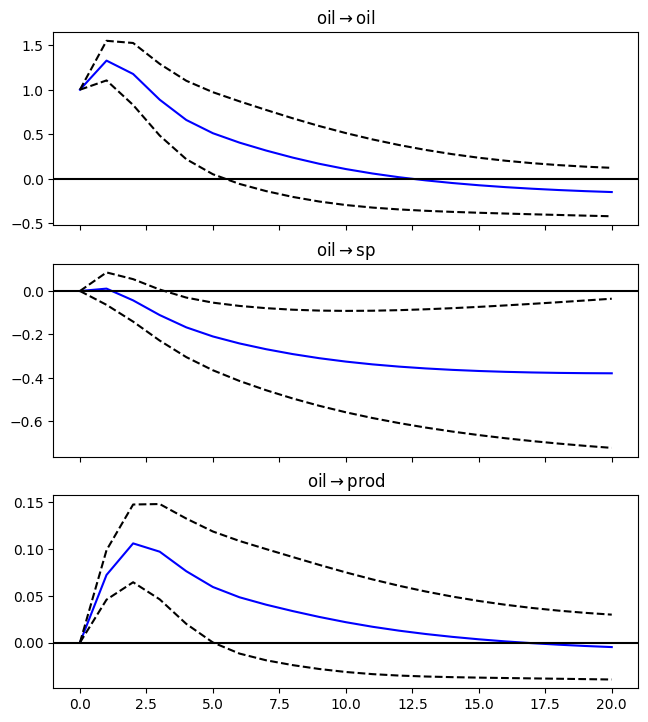

In [6]:
# VAR model
from statsmodels.tsa.api import VAR
# make the VAR model
model = VAR(sample)
# Estimate VAR
results = model.fit(2)
# Assign impulse response functions (IRFs)
irf = results.irf(20)
# Plot IRFs
plt = irf.plot(orth=False,impulse='oil',figsize=(6.5,7.5));
plt.suptitle('');